In [27]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2024-11-21 05:55:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   201MB/s    in 0.3s    

2024-11-21 05:55:22 (201 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [28]:
import os
from PIL import Image
import numpy as np

cats_dir = os.path.join(train_dir, "cats")
dogs_dir = os.path.join(train_dir, "dogs")

# Get the number of images available in both directories
num_cats = len(os.listdir(cats_dir))
num_dogs = len(os.listdir(dogs_dir))

# Use the smaller number to prevent out-of-range errors
number_of_examples = min(num_cats, num_dogs)

x_train = []
y_train = []

i = 0
while i < number_of_examples:
    if i % 2 == 0:
        im = Image.open(os.path.join(cats_dir, os.listdir(cats_dir)[i])).convert("RGB")
    else:
        im = Image.open(os.path.join(dogs_dir, os.listdir(dogs_dir)[i])).convert("RGB")

    # Resize image to a fixed size, e.g., 128x128
    im_resized = im.resize((128, 128))
    x_train.append(np.array(im_resized))
    y_train.append(1 if i % 2 == 0 else 0)
    i += 1


In [29]:
import tensorflow as tf

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(150, 150, 3),
    pooling='avg',
    classes=2,
    weights='imagenet'
)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
from tensorflow.keras import layers, models

pretrained_model.trainable = False

model = models.Sequential([
    pretrained_model,
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step - accuracy: 0.4935 - loss: 0.7491 - val_accuracy: 0.5200 - val_loss: 0.6886
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.5377 - loss: 0.6997 - val_accuracy: 0.5530 - val_loss: 0.6847
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.5146 - loss: 0.6910 - val_accuracy: 0.5640 - val_loss: 0.6831
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - accuracy: 0.5492 - loss: 0.6873 - val_accuracy: 0.5230 - val_loss: 0.6870
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.5216 - loss: 0.6904 - val_accuracy: 0.5300 - 

In [33]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


from tensorflow.keras.preprocessing import image
import numpy as np
img_path = 'cat.jpg'

img = image.load_img(img_path, target_size=(150, 150))

img_array = image.img_to_array(img) / 255.0

img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

print("Cat" if prediction[0] > 0.5 else "Dog")



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.4977 - loss: 0.6879
Validation Loss: 0.6869524121284485
Validation Accuracy: 0.5299999713897705
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Cat


In [37]:
pretrained_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tuning_history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 651ms/step - accuracy: 0.7043 - loss: 0.8116 - val_accuracy: 0.5000 - val_loss: 2.0363
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 288ms/step - accuracy: 0.7044 - loss: 0.5878 - val_accuracy: 0.5000 - val_loss: 61.1937
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.8287 - loss: 0.4064 - val_accuracy: 0.5000 - val_loss: 0.7307


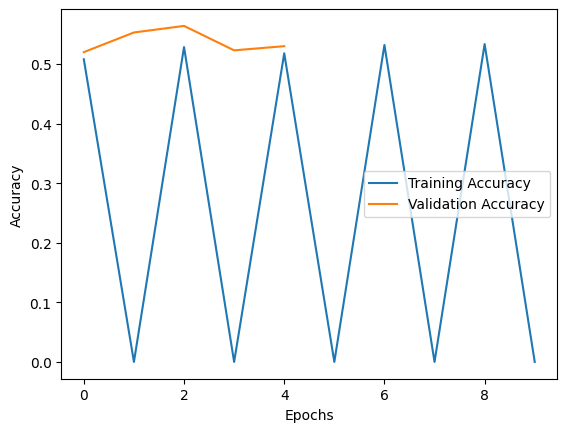

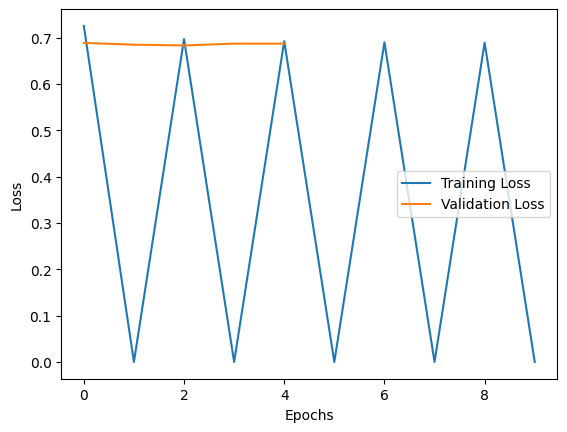

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
from tensorflow.keras import layers

# Add a Dense layer with 1 unit and a sigmoid activation function for binary classification
x = pretrained_model.output
x = layers.Dense(1, activation='sigmoid')(x)

# Create a new model with the modified output layer
model = tf.keras.Model(inputs=pretrained_model.input, outputs=x)

# Compile the model again with binary crossentropy and accuracy as the metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Now you can evaluate the model on the validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
print(f'Validation Accuracy: {val_acc:.4f}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.5131 - loss: 2.6169
Validation Accuracy: 0.5000
